In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import pvlib

In [3]:
# where is Pechbusque...
# latitude, longitude, name, altitude, timezone

coordinates = [
    (43.5, 1.47, 'Pechbusque', 270, 'utc')
]

In [4]:
# module, onduleur...

sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

In [5]:
# récupère météo

tmys = []

for location in coordinates:
    latitude, longitude, name, altitude, timezone = location
    weather = pvlib.iotools.get_pvgis_tmy(latitude, longitude, map_variables=True)[0]  # map_variables=True ?!
    weather.index.name = "utc_time"
    
    tmys.append(weather)

Text(0, 0.5, 'Yearly energy yield (W hr)')

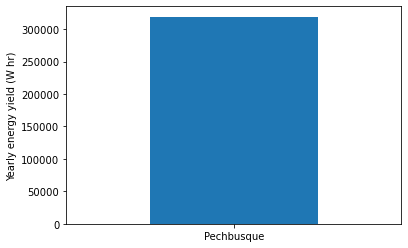

In [6]:
# Design PV OOP

from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain

energies = {}

for location, weather in zip(coordinates, tmys):
    latitude, longitude, name, altitude, timezone = location
    
    location = Location(
        latitude,
        longitude,
        name=name,
        altitude=altitude,
        tz=timezone,
    )
    
    mount = FixedMount(surface_tilt=latitude, surface_azimuth=180)
    
    array = Array(
        mount=mount,
        module_parameters=module,
        temperature_model_parameters=temperature_model_parameters,
    )
    
    system = PVSystem(arrays=[array], inverter_parameters=inverter)
    
    mc = ModelChain(system, location)
    
    mc.run_model(weather)
    annual_energy = mc.results.ac.sum()
    
    energies[name] = annual_energy

energies = pd.Series(energies)

energies.plot(kind='bar', rot=0)

plt.ylabel('Yearly energy yield (W hr)')